# Data EDA

This notebook profiles generated raw, processed, and feature datasets.

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

base = Path('data') if Path('data').exists() else Path('../data')
raw_telemetry = pd.read_csv(base / 'raw' / 'telemetry.csv')
raw_weather = pd.read_csv(base / 'raw' / 'weather.csv')
processed = pd.read_csv(base / 'processed' / 'telemetry_processed.csv')
features = pd.read_csv(base / 'processed' / 'ceiling_risk_features.csv')

raw_telemetry.head()

,event_id,drone_id,timestamp_iso,lat,lon,altitude_ft,vertical_speed_fps,ground_speed_fps,heading_deg,gps_fix_ok,signal_strength,message_delay_ms,is_interpolated
0,D-2001-0000,D-2001,2026-02-13T12:00:00Z,37.620000,-122.349800,228.0,1.2,14.000,95.000,0,82,125,1
1,D-2001-0001,D-2001,2026-02-13T12:00:01Z,37.620011,-122.349800,229.2,1.2,14.150,95.125,1,91,35,0
2,D-2001-0002,D-2001,2026-02-13T12:00:02Z,37.620022,-122.349801,230.4,1.2,14.299,95.250,1,91,35,0
3,D-2001-0003,D-2001,2026-02-13T12:00:03Z,37.620033,-122.349803,231.6,1.2,14.445,95.374,1,91,35,0
4,D-2001-0004,D-2001,2026-02-13T12:00:04Z,37.620044,-122.349805,232.8,1.2,14.589,95.497,1,91,36,0


In [2]:
summary = {
    'raw_telemetry_rows': len(raw_telemetry),
    'raw_weather_rows': len(raw_weather),
    'processed_rows': len(processed),
    'feature_rows': len(features),
    'drones': raw_telemetry['drone_id'].nunique(),
}
pd.Series(summary)

raw_telemetry_rows    240
raw_weather_rows      240
processed_rows        240
feature_rows          240
drones                  2
dtype: int64

In [3]:
grouped = features.groupby('drone_id', as_index=False).agg(
    avg_risk=('risk_score', 'mean'),
    p95_risk=('risk_score', lambda s: s.quantile(0.95)),
    alert_share=('ceiling_cross_within_8s', 'mean')
)
grouped

,drone_id,avg_risk,p95_risk,alert_share
0,D-2001,0.800836,0.991800,0.65
1,D-2002,0.249102,0.460145,0.00


### What this table means
- `D-2001` is the riskier drone in this scenario: higher average risk, higher peak risk, and higher alert share.
- `D-2002` stays mostly in safer operating space in this run.
- Simple takeaway: this setup is intentionally built to show two different risk behaviors clearly.

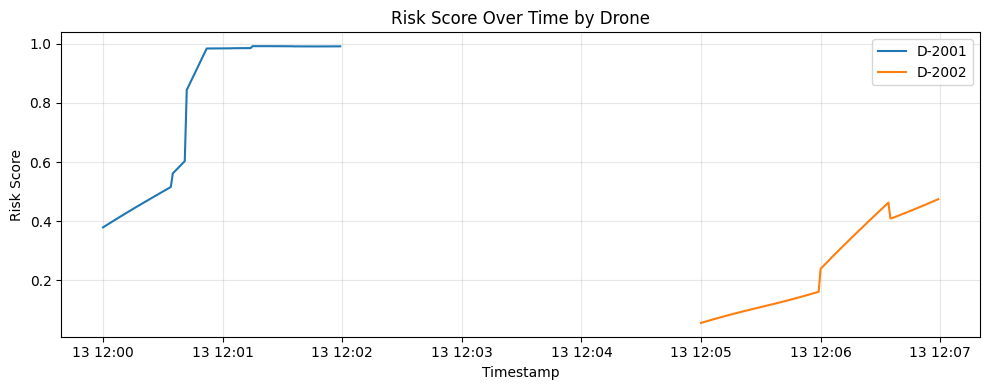

In [4]:
plot_df = features.copy()
plot_df['timestamp_iso'] = pd.to_datetime(plot_df['timestamp_iso'])
fig, ax = plt.subplots(figsize=(10, 4))
for drone_id, part in plot_df.groupby('drone_id'):
    ax.plot(part['timestamp_iso'], part['risk_score'], label=drone_id)
ax.set_title('Risk Score Over Time by Drone')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Risk Score')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()

### What this plot means
- The blue and orange lines are not behaving the same: one drone stays much riskier over time.
- In this dataset, that is expected because one drone climbs more aggressively and also has a lower allowed ceiling.
- Simple takeaway: risk is not just about speed; local airspace limits matter too.

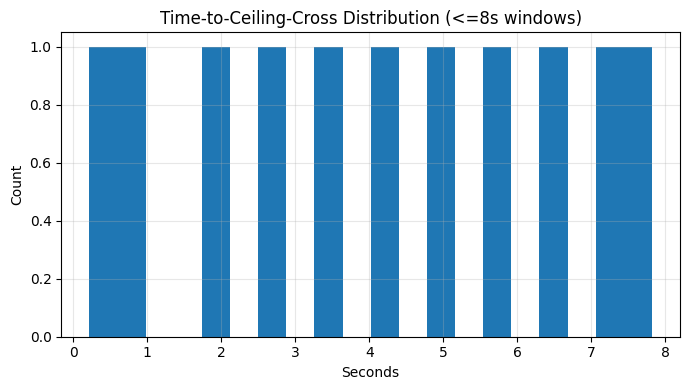

In [5]:
ttc = pd.to_numeric(features['time_to_ceiling_cross_sec'], errors='coerce').dropna()
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(ttc, bins=20)
ax.set_title('Time-to-Ceiling-Cross Distribution (<=8s windows)')
ax.set_xlabel('Seconds')
ax.set_ylabel('Count')
ax.grid(alpha=0.3)
plt.tight_layout()

### What this chart means
- This chart shows how much warning time is left before a possible ceiling crossing.
- Smaller numbers mean less reaction time.
- Easy rule of thumb for operations:
- `critical`: less than 2 seconds left (act immediately)
- `warning`: 2 to 5 seconds left (prepare and respond)
- `advisory`: more than 5 seconds left (monitor closely)
- This is a small synthetic run, so treat it as a walkthrough example, not a final production threshold policy.

## Feature Inputs for Altitude Warning

This section isolates the primary model inputs so readers can quickly understand which features drive near-term ceiling-risk indicators.

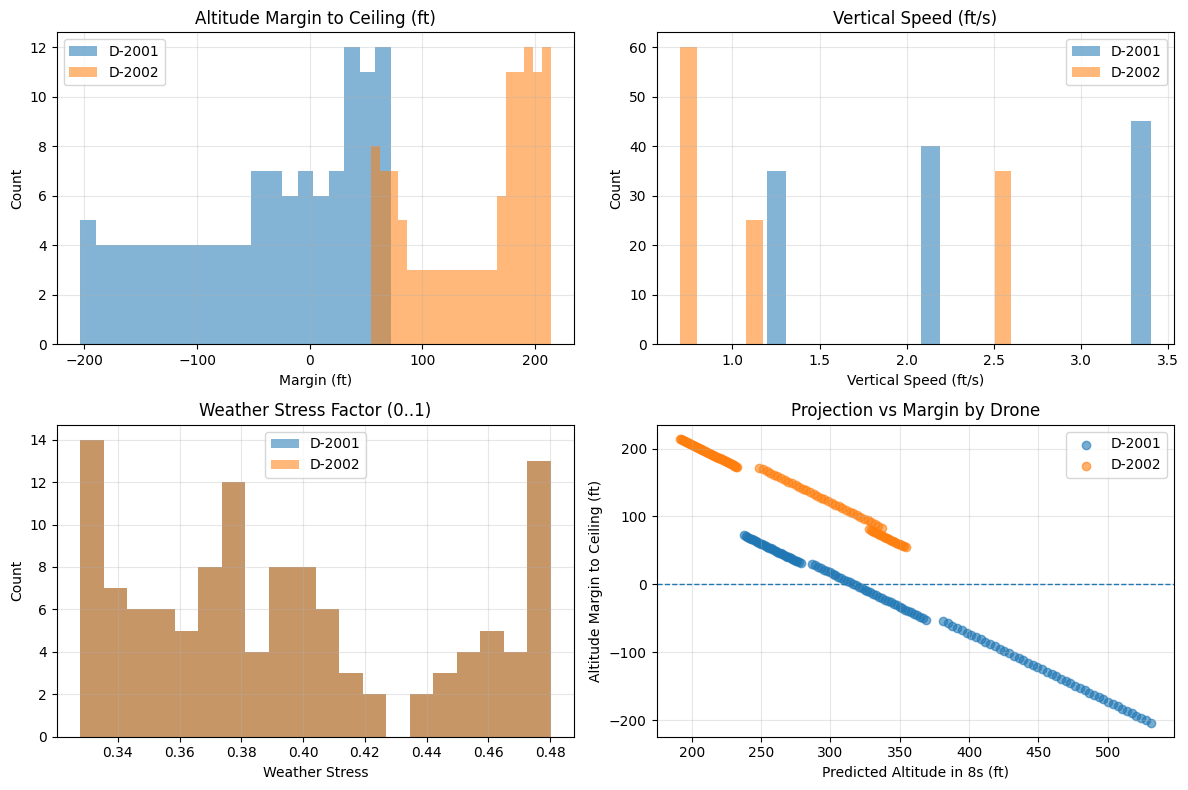

In [6]:
feature_cols = [
    'drone_id',
    'altitude_margin_to_ceiling_ft',
    'vertical_speed_fps',
    'weather_stress_factor',
    'predicted_altitude_ft_8s',
    'ceiling_cross_within_8s'
]
plot_features = features[feature_cols].copy()
drone_palette = {'D-2001': '#1f77b4', 'D-2002': '#ff7f0e'}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for drone_id, part in plot_features.groupby('drone_id'):
    axes[0, 0].hist(part['altitude_margin_to_ceiling_ft'], bins=20, alpha=0.55,
                   label=drone_id, color=drone_palette.get(drone_id))
axes[0, 0].set_title('Altitude Margin to Ceiling (ft)')
axes[0, 0].set_xlabel('Margin (ft)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend()

for drone_id, part in plot_features.groupby('drone_id'):
    axes[0, 1].hist(part['vertical_speed_fps'], bins=20, alpha=0.55,
                   label=drone_id, color=drone_palette.get(drone_id))
axes[0, 1].set_title('Vertical Speed (ft/s)')
axes[0, 1].set_xlabel('Vertical Speed (ft/s)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend()

for drone_id, part in plot_features.groupby('drone_id'):
    axes[1, 0].hist(part['weather_stress_factor'], bins=20, alpha=0.55,
                   label=drone_id, color=drone_palette.get(drone_id))
axes[1, 0].set_title('Weather Stress Factor (0..1)')
axes[1, 0].set_xlabel('Weather Stress')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend()

for drone_id, part in plot_features.groupby('drone_id'):
    axes[1, 1].scatter(part['predicted_altitude_ft_8s'], part['altitude_margin_to_ceiling_ft'],
                       alpha=0.6, label=drone_id, color=drone_palette.get(drone_id))
axes[1, 1].axhline(0, linestyle='--', linewidth=1)
axes[1, 1].set_title('Projection vs Margin by Drone')
axes[1, 1].set_xlabel('Predicted Altitude in 8s (ft)')
axes[1, 1].set_ylabel('Altitude Margin to Ceiling (ft)')
axes[1, 1].legend()

for ax in axes.flat:
    ax.grid(alpha=0.3)

plt.tight_layout()


### What these feature plots mean
- Colors separate the two drones so it is easier to see who contributes to risky regions.
- Negative altitude margin means the drone is at or beyond its ceiling buffer.
- Higher vertical speed usually pushes risk up faster.
- Weather stress in this run acts like a multiplier: it increases pressure, but it is not the only cause of risk.
- Projection vs margin gives a quick picture of "how close" and "how soon" at the same time.